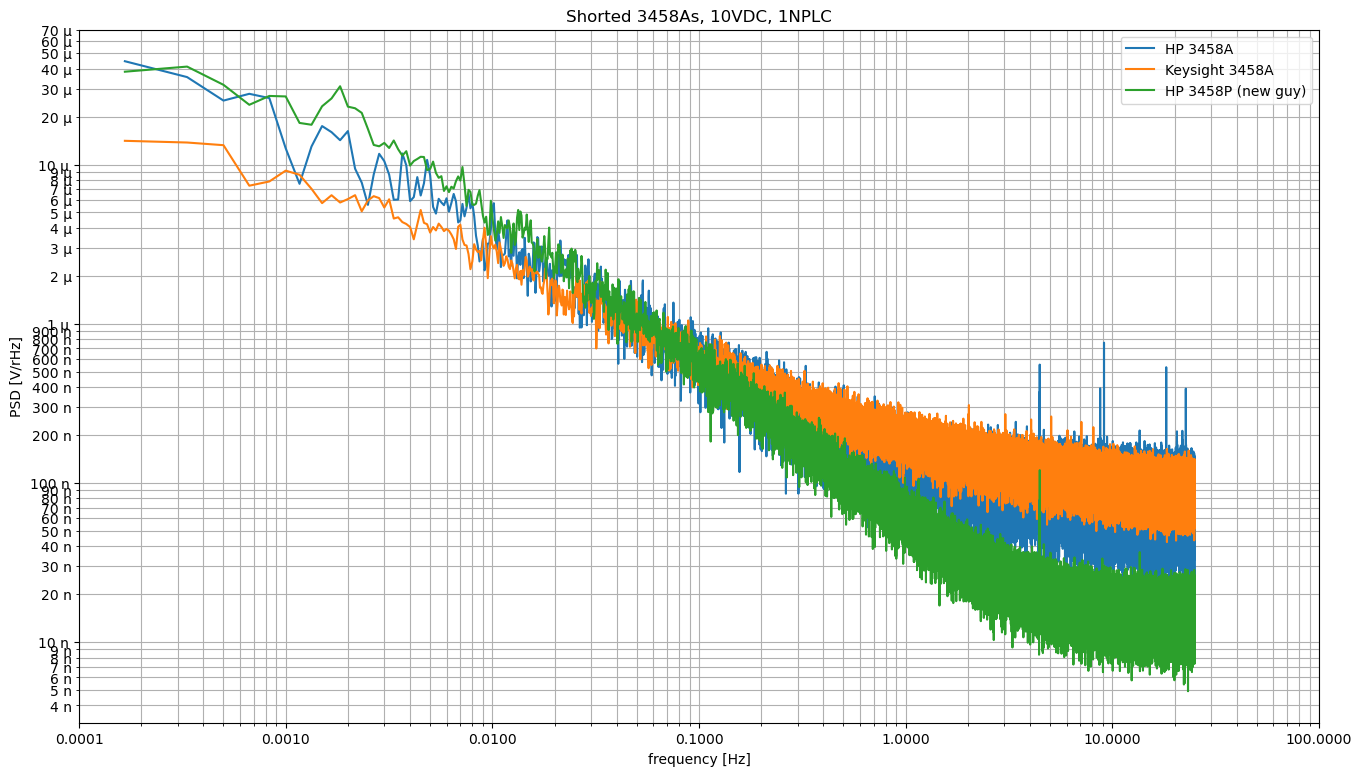

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from matplotlib.ticker import EngFormatter
from matplotlib.ticker import FormatStrFormatter

# Array from .csv
arr=np.genfromtxt('https://raw.githubusercontent.com/marcoreps/3458a/main/csv/HP_3458A_short_10V_1NPLC_.csv',delimiter=',')
fs = 50 # 1 NPLC sampling frequency
f, S = scipy.signal.welch(arr[:,1], fs, nperseg=300000)
f = f[1:-1]
S = np.sqrt(S[1:-1])

fig,ax = plt.subplots(figsize=(16,9))

#plt.figure(facecolor='white') # fix for exporting png file
plt.loglog()
plt.xlim([0.0001,100])
plt.xlabel('frequency [Hz]')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.yaxis.set_major_formatter(EngFormatter())
ax.yaxis.set_minor_formatter(EngFormatter())

#plt.yticks((1E-9, 3E-9, 1E-8, ))
plt.ylabel('PSD [V/rHz]')
plt.grid(True, which="both")
plt.title('Shorted 3458As, 10VDC, 1NPLC')

plt.plot(f, S, label='HP 3458A')


arr=np.genfromtxt('https://raw.githubusercontent.com/marcoreps/3458a/main/csv/Keysight_3458A_short_10V_1NPLC_.csv',delimiter=',')
f, S = scipy.signal.welch(arr[:,1], fs, nperseg=300000)
f = f[1:-1]
S = np.sqrt(S[1:-1])
plt.plot(f, S, label='Keysight 3458A')



arr=np.genfromtxt('https://raw.githubusercontent.com/marcoreps/3458a/main/csv/HP_3458P_short_10V_1NPLC_2024-09-11.csv',delimiter=',')
f, S = scipy.signal.welch(arr[:,1], fs, nperseg=300000)
f = f[1:-1]
S = np.sqrt(S[1:-1])
plt.plot(f, S, label='HP 3458P (new guy)')



plt.legend()